# Delay experiment with Steane Code (measurement in $Z_L$):

This experiment consist of preparing the state $\ket{0}_L$ using the Steane Code, add a time delay and measure the state in the observable $Z_L$. We will run two circuits, in the first one we measure the state after the delay, and in the second one we apply the error correction procedure for the Steane Code after the delay.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RXGate, UGate, IGate
from qiskit.circuit import QuantumCircuit, Delay
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService

import warnings

import sys
import os

# Add "../../.." to the sys.path to use SteaneCodeCircuit class
sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
from objects.steane_code_circuit import SteaneCodeCircuit
from functions.transpile import get_layout
from utils import get_transpile

In [2]:
# Define IBM service
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)

### Test of delay with IBM:

First we see how to apply a time delay using IBM. We use the gate $\textcolor{orange}{\text{Delay()}}$ from $\textcolor{green}{\text{qiskit.circuit}}$. The Delay gate has one parameter $\text{dt}$ indicating the time duration of the delay in "backend natural units". Once we select a backend we can see the value of one $\text{dt}$ in seconds with $\textcolor{orange}{\text{backend.configuration().dt}}$

In this test we run a circuit with one qubit where we apply an $X$ gate and then a delay of $1000 \hspace{3pt} \text{dt}$. Then we compute the *error rate* as:

$$\text{Error-rate} = \frac{\hspace{3pt} \ket{0}\text{'s} \hspace{3pt} \text{measured}}{\text{shots}}$$

In [ ]:
# Create quantum circuit and add delay
qc = QuantumCircuit(1)
qc.x(0)
qc.append(Delay(1), [0]) # dt [Backend dependent time unit]
qc.measure_all()

qc.draw("mpl")

In [ ]:
# See available backends for the job
print("Available Back-ends for this job:")
service.backends()
service.backends(simulator=False, operational=True, min_num_qubits=23)
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)

In [ ]:
# Get the dt of the selected backend in seconds
dt = backend.configuration().dt
dt

In [ ]:
sampler = SamplerV2(backend)
shots = 124

# transpile circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=1)

In [ ]:
# Run circuit in backend
job = sampler.run([isa_circuit], shots = shots)
pub_result = job.result()

# Get measures
result = pub_result[0]
meas = result['__value__']['data']['meas'].get_counts()
print(f" > Resultados obtenidos: {meas}")

# Compute the error rate
error_rate = 1 - meas['0']/shots
print(f" > Error rate: {error_rate}")

### Experiment 1: Circuit without error correction

We use the class $\textcolor{orange}{\text{SteaneCodeCircuit()}}$ to create a logical circuit using the Steane Code. Recall that this experiment consits of encoding the state $\ket{0}_L$, apply a time delay $t$ in all of the 7 qubits of the code and then measure the state in $Z_L$. Therefore the experiment is as follows:

$$\text{Encode } \ket{0}_L \rightarrow \text{Delay}(t) \rightarrow \text{Measure }(\text{in observable } Z_L)$$

The expected result of the measurement given that there is no error is $\ket{0}$. Therefore we can compute the *error rate* as in the first example:

$$\text{Error-rate} = \frac{\hspace{3pt} \ket{1}\text{'s} \hspace{3pt} \text{measured}}{\text{shots}}$$

In [5]:
# Select backend
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
shots = 2500

In [6]:
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [7]:
# Create a circuit with no delay to get the layout
qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
qc_steane.encode(append=True)
qc_steane.barrier()
qc_steane.measure_all('z')

qc = qc_steane.physical_quantum_circuit
qc.draw("mpl")


isa_circuit = get_transpile(qc, backend, iterations=10, scheduling_method="asap", optimization_level=3)
initial_layout = get_layout(isa_circuit, qb_len=8)

# Use pre-defined initial layout
initial_layout = [62, 61, 63, 72, 64, 60, 65, 54]

In [8]:
print(f" > Initial Layout: {initial_layout}")

 > Initial Layout: [62, 61, 63, 72, 64, 60, 65, 54]


In [9]:
t_array = [t*9_000 for t in range(0, 6)]
print(f" > Delays in dt: {t_array}")
print(f" > Delays un us: {[round(t*dt * 10**(-3) , 3) for t in t_array]}")

 > Delays in dt: [0, 9000, 18000, 27000, 36000, 45000]
 > Delays un us: [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]


In [ ]:
# dt = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 90000, 100000]

circuits = []

for t in t_array:
    # Generate circuit and measure in the z basis
    qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
    qc_steane.encode(append=True)
    qc_steane.barrier()
    
    for i in range(qc_steane.physical_qubit_count):
        qc_steane.append_unitary_error(Delay(t), i) # Add delay

    qc_steane.barrier()
    qc_steane.measure_all('z')



    # Get physical_quantum_circuit and transpile it
    qc = qc_steane.physical_quantum_circuit
    isa_circuit = get_transpile(qc, backend, iterations=10, scheduling_method="asap", optimization_level=3, initial_layout=initial_layout)
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {isa_circuit.depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")

    # QuantumCircuit.duration is deprecated. Ignore the warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        total_duration = isa_circuit.duration * dt * 10**(-3)
        print(f"Estimated Total Duration: {round(total_duration, 3)} us\n")

Circuit Depth: 139
Delay Duration: 0.0 us
Estimated Total Duration: 21.511 us

Circuit Depth: 141
Delay Duration: 2.0 us
Estimated Total Duration: 23.513 us

Circuit Depth: 140
Delay Duration: 4.0 us
Estimated Total Duration: 25.511 us

Circuit Depth: 141
Delay Duration: 6.0 us
Estimated Total Duration: 27.513 us

Circuit Depth: 140
Delay Duration: 8.0 us
Estimated Total Duration: 29.511 us

Circuit Depth: 141
Delay Duration: 10.0 us
Estimated Total Duration: 31.513 us



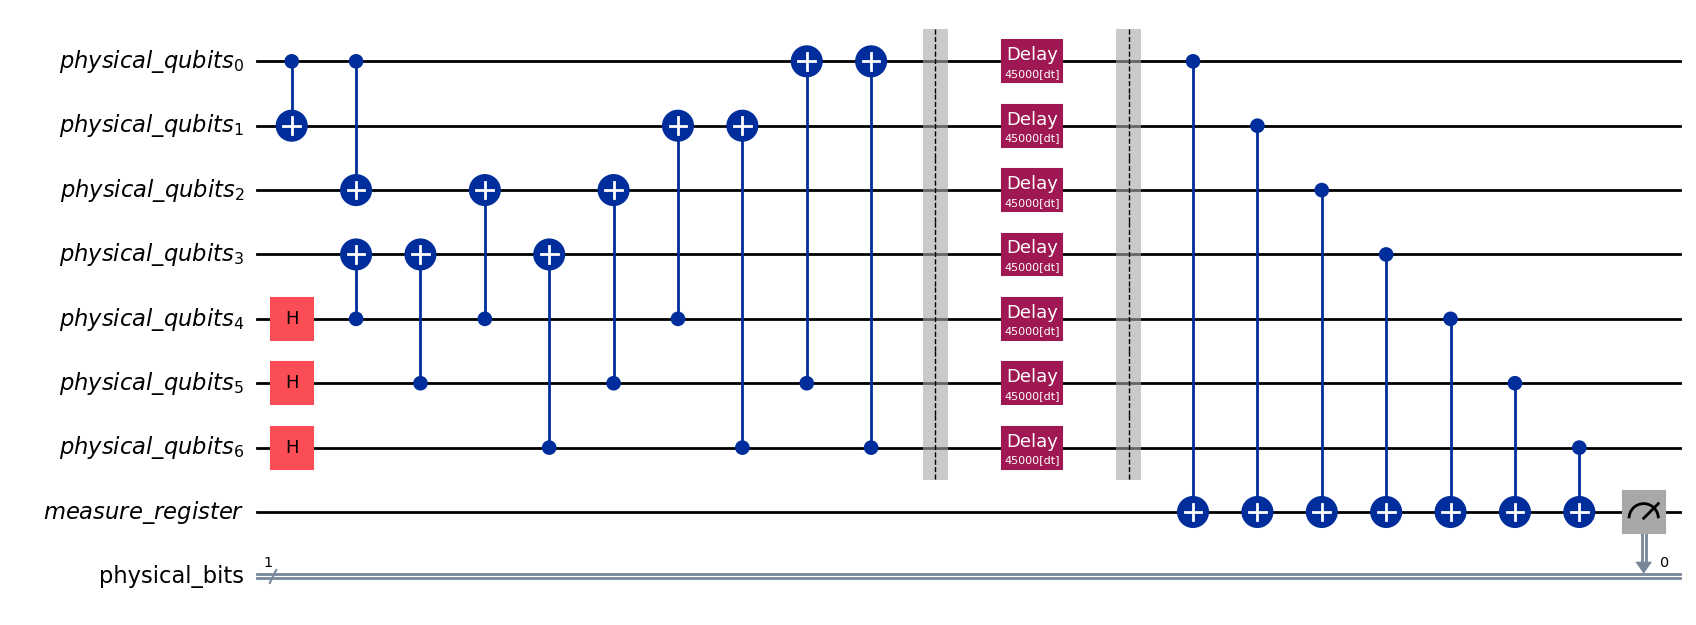

In [14]:
qc.draw("mpl")

In [ ]:
print(f" > Depth of original circuit (before transpilation): {qc.depth()}")

mean_depth = 0
for circ in circuits:
    mean_depth += circ.depth()

mean_depth = mean_depth/len(circuits)
    
print(f" > Mean depth of transpiled circuits: {mean_depth}")

 > Depth of original circuit (before transpilation): 15
 > Mean depth of transpiled circuits: 140.33333333333334


In [ ]:
# Warning. This run the circuit
job = sampler.run(circuits, shots = shots)
job_id = job.job_id()

print(f" > job_id: {job_id}")
print(f" > job_status: {job.status()}")

In [ ]:
# Opening JSON file
import json
real_distribution = {'0':1} # Expect result zero with probability 1

metadata = {'expected_distribution': real_distribution, 't_array': t_array, 'initial_layout':initial_layout}
json_file = "experiments.json"

experiment_name = "delay_measureZL_noCorrection"

with open(json_file) as f:
    experiment_results = json.load(f)


if (experiment_name in experiment_results.keys()):
    # Check for repeated job_id. If job_id is not repeated we add the job to the json
    results = experiment_results[experiment_name]
    if job_id not in [results[i]['job_id'] for i in range(len(results))]:
        experiment_results[experiment_name].append({"job_id":job_id, "metadata":metadata})

else:
    experiment_results[experiment_name] = [{"job_id":job_id, "metadata":metadata}]


# Writing back to JSON
with open(json_file, "w") as f:
    f.write(json.dumps(experiment_results, indent=2))

### Experiment 2: Circuit with error correction

This experiment is exactly the same as the first one, but we apply the error correction procedure of the Steane Code before the measurement in the observable $Z_L$. Therefore we can represent the experiment as follows:

$$\text{Encode } \ket{0}_L  \rightarrow \text{Delay}(dt) \rightarrow \text{Error-Correction} \rightarrow \text{Measure } (\text{in observable } Z_L)$$

Again, the expected result of the measurement is $\ket{0}$, so we compute the error rate as:

$$\text{Error-rate} = \frac{\hspace{3pt} \ket{1}\text{'s} \hspace{3pt} \text{measured}}{\text{shots}}$$

In [3]:
# Select the backend again
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
shots = 2500

In [4]:
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [5]:
# Create a circuit with no delay to get the layout
qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
qc_steane.encode(append=True)
qc_steane.barrier()
qc_steane.correct(append = True)
qc_steane.barrier()

qc_steane.measure_all('z')

qc = qc_steane.physical_quantum_circuit
qc.draw("mpl")


isa_circuit = get_transpile(qc, backend, iterations=10, scheduling_method="asap", optimization_level=3)
initial_layout = get_layout(isa_circuit, qb_len=14)

# Pre-select initial layout
initial_layout = [118, 119, 110, 117, 100, 120, 116, 101, 99, 121, 98, 102, 103, 97]

In [6]:
print(f" > Initial Layout: {initial_layout}")

 > Initial Layout: [118, 119, 110, 117, 100, 120, 116, 101, 99, 121, 98, 102, 103, 97]


In [7]:
t_array = [t*9_000 for t in range(0, 6)]
print(f" > Delays in dt: {t_array}")
print(f" > Delays un us: {[round(t*dt * 10**(-3) , 3) for t in t_array]}")

 > Delays in dt: [0, 9000, 18000, 27000, 36000, 45000]
 > Delays un us: [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]


In [8]:
circuits = []

for t in t_array:
    # Generate the circuit with error crrection
    qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
    qc_steane.encode(append = True)
    for i in range(qc_steane.physical_qubit_count):
        qc_steane.append_unitary_error(Delay(t), i)

    qc_steane.correct(append=True)
    qc_steane.measure_all('z')

    # Extract and transpile circuit
    qc = qc_steane.physical_quantum_circuit
    isa_circuit = get_transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=initial_layout)
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {isa_circuit.depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")

    # QuantumCircuit.duration is deprecated. Ignore the warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        total_duration = isa_circuit.duration * dt * 10**(-3)
        print(f"Estimated Total Duration: {round(total_duration, 3)} us\n")

Circuit Depth: 1571
Delay Duration: 0.0 us
Estimated Total Duration: 222.585 us

Circuit Depth: 1573
Delay Duration: 2.0 us
Estimated Total Duration: 227.886 us

Circuit Depth: 1574
Delay Duration: 4.0 us
Estimated Total Duration: 233.881 us

Circuit Depth: 1574
Delay Duration: 6.0 us
Estimated Total Duration: 239.886 us

Circuit Depth: 1574
Delay Duration: 8.0 us
Estimated Total Duration: 245.881 us

Circuit Depth: 1537
Delay Duration: 10.0 us
Estimated Total Duration: 252.156 us



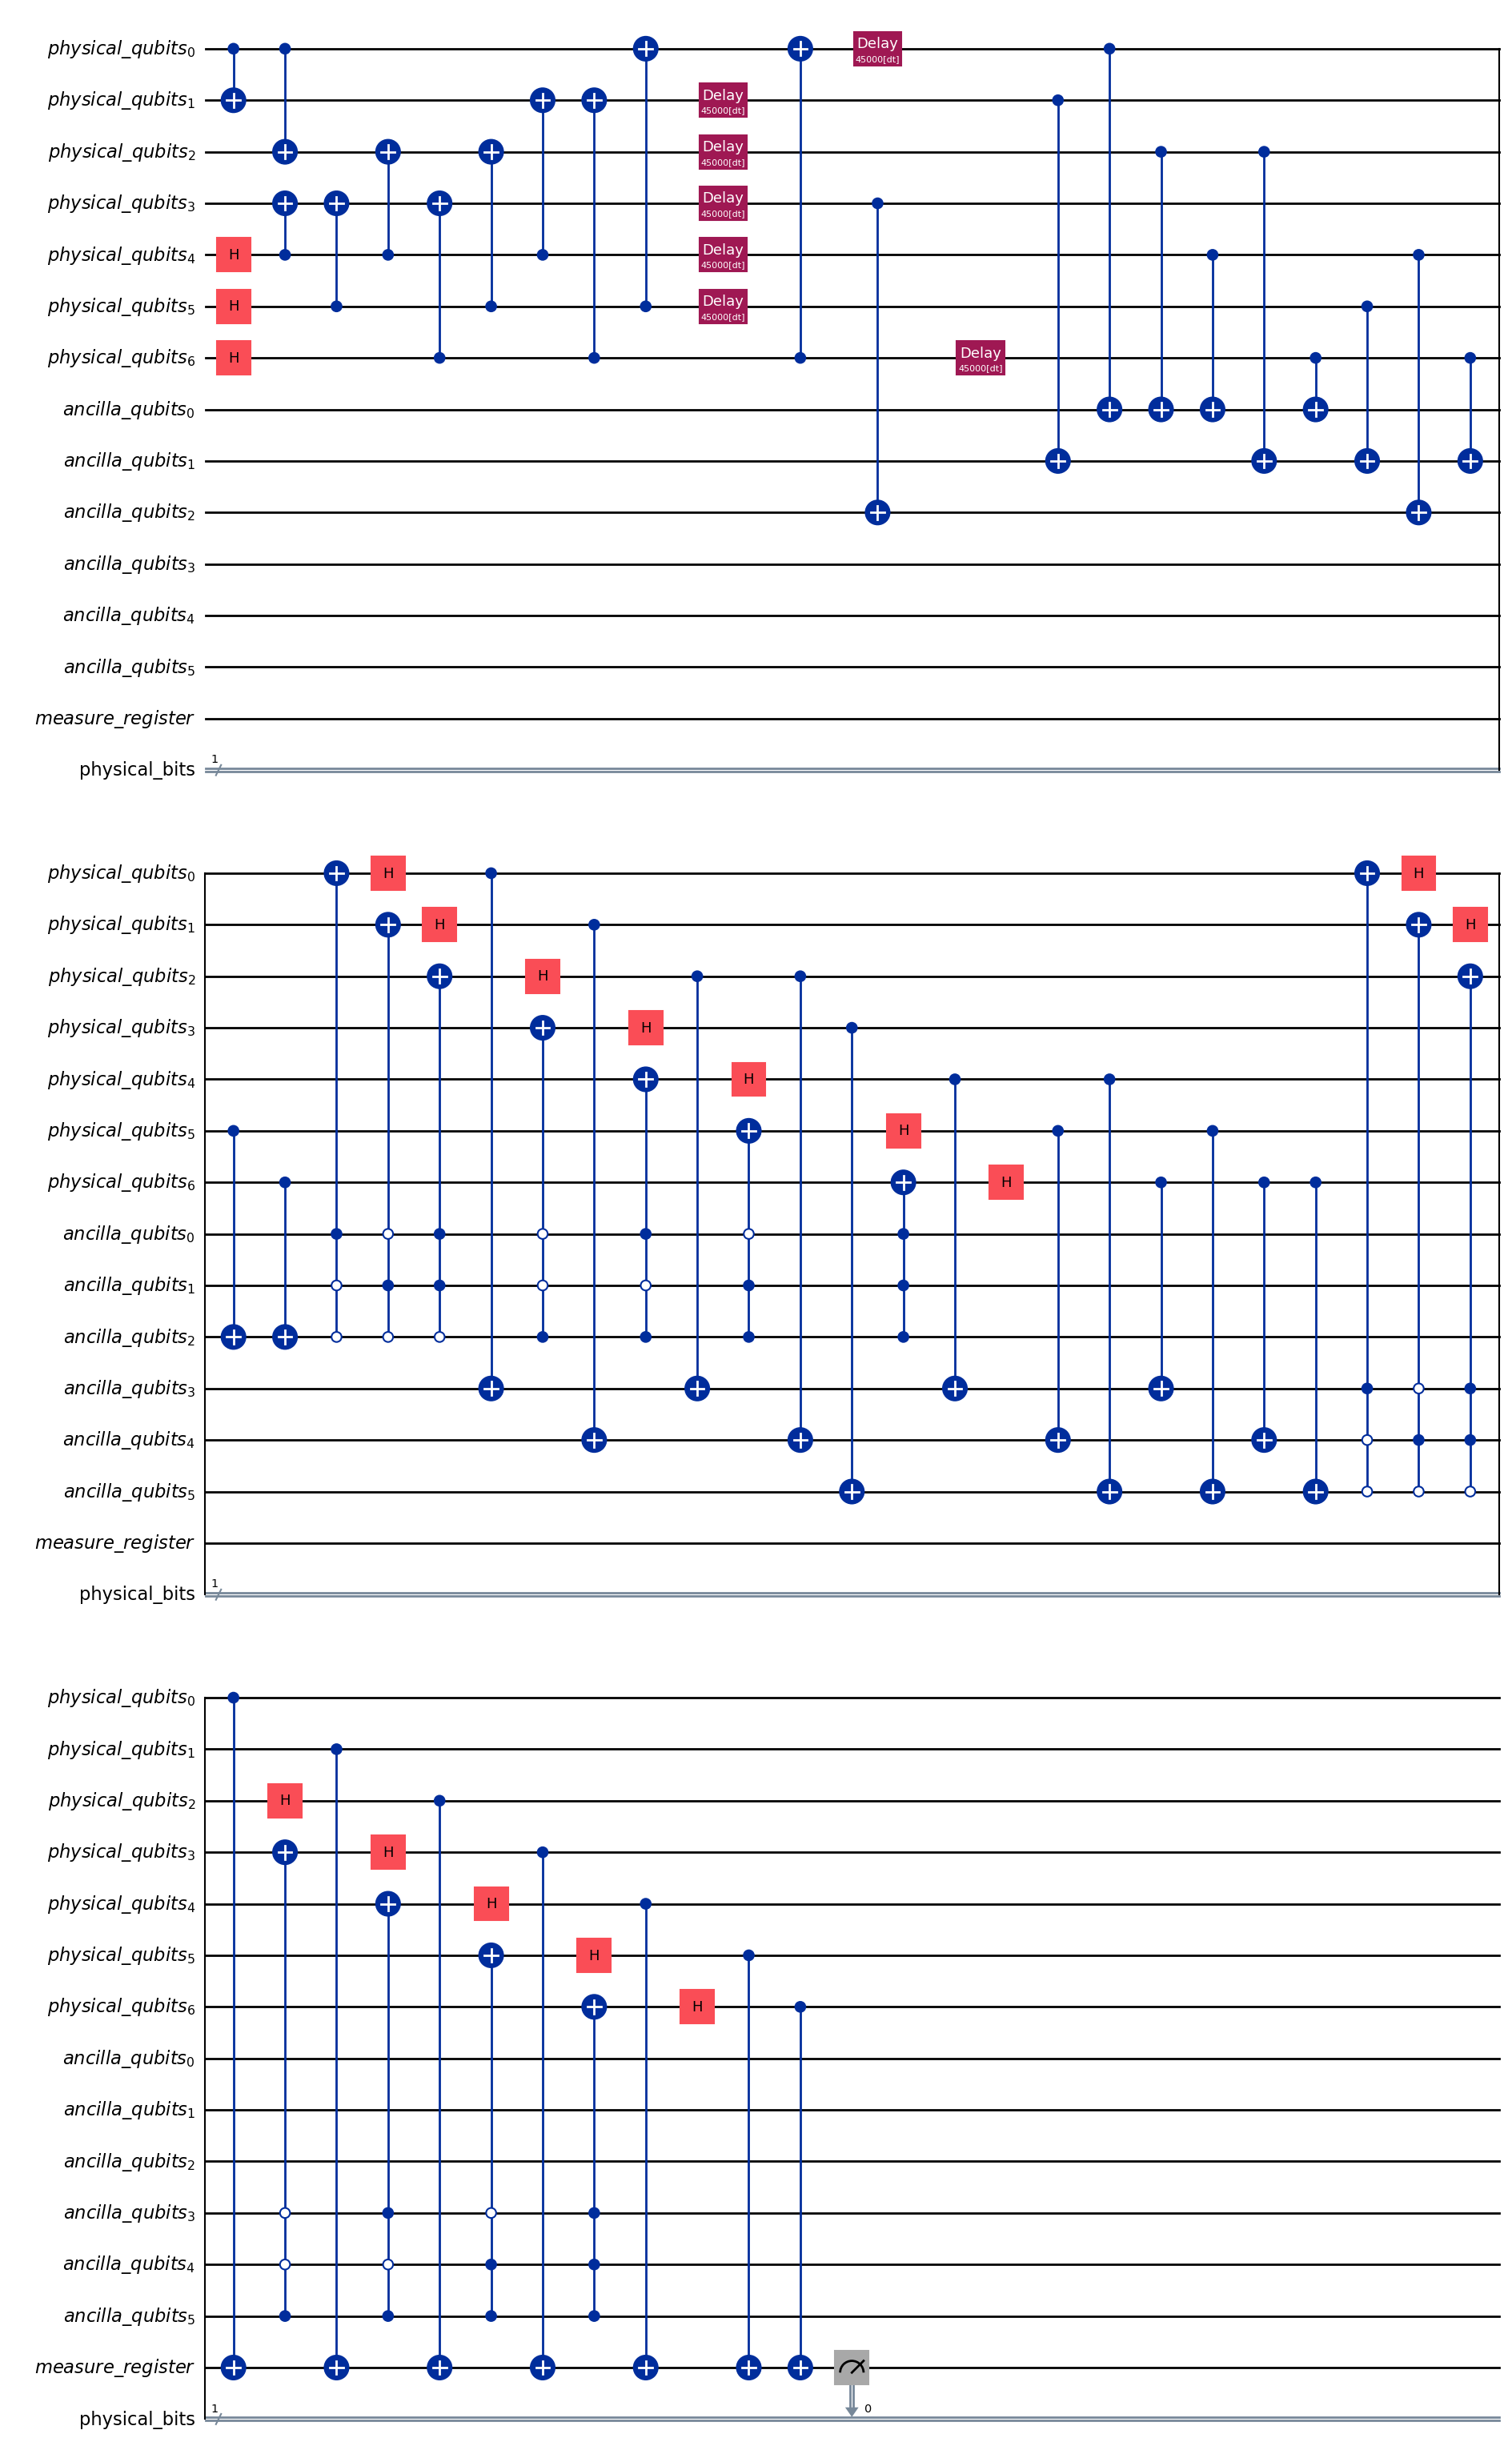

In [9]:
qc.draw("mpl")

In [10]:
print(f" > Depth of original circuit (before transpilation): {qc.depth()}")

mean_depth = 0
for circ in circuits:
    mean_depth += circ.depth()

mean_depth = mean_depth/len(circuits)
    
print(f" > Mean depth of transpiled circuits: {mean_depth}")

 > Depth of original circuit (before transpilation): 34
 > Mean depth of transpiled circuits: 1567.1666666666667


In [11]:
# Run the job
job = sampler.run(circuits, shots = shots)
job_id = job.job_id()

print(f" > job_id: {job_id}")
print(f" > job_status: {job.status()}")

 > job_id: cys7j811j2e0008v044g
 > job_status: QUEUED


In [12]:
# Opening JSON file
import json
real_distribution = {'0':1} # Expect result zero with probability 1

metadata = {'expected_distribution': real_distribution, 't_array': t_array, 'initial_layout':initial_layout}
json_file = "experiments.json"

experiment_name = "delay_measureZL_Correction"

with open(json_file) as f:
    experiment_results = json.load(f)


if (experiment_name in experiment_results.keys()):
    # Check for repeated job_id. If job_id is not repeated we add the job to the json
    results = experiment_results[experiment_name]
    if job_id not in [results[i]['job_id'] for i in range(len(results))]:
        experiment_results[experiment_name].append({"job_id":job_id, "metadata":metadata})

else:
    experiment_results[experiment_name] = [{"job_id":job_id, "metadata":metadata}]


# Writing back to JSON
with open(json_file, "w") as f:
    f.write(json.dumps(experiment_results, indent=2))
